# AEWS Python Notebook 05: checking AE/EE's PQ mask

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 29 April 2016

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

In this notebook, we review the following concepts:

* loading Landsat PQ data "manually"
* loading Landsat PQ data using the Analytics / Execution engines
* comparison of both PQ masks w.r.t Landsat data


## Preliminaries

As shown in the previous notebook in this series, masking of the Landsat data using the Analytics / Execution Engines (AE/EE) somewhat leaves to be desired. This iPython notebook is written to check whether this is a result of the AE/EE's PQ mask itself, or the way the AE/EE carries out the masking of Landsat data on the basis of a (correct) PQ mask. The ultimate purpose is basically to decide whether (at this stage of the AGDC v2.0 developments) it is possible to use the AE/EE to load up the PQ mask together with the Landsat data, rather than having to "manually" create the PQ mask.

Both the "manual" PQ masking and AE/EE PQ masking operations were tested in earlier notebooks, so the code below essentially simply duplicates the relevant sections of _'AEWS Python Notebook 02'_ and _'AEWS Python Notebook 04'_ for the above purpose.

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```$ module use /g/data/v10/public/modules/modulefiles --append
$ module load agdc-py2-dev```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module

from datetime import datetime
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine
from datacube.analytics.utils.analytics_utils import plot

## Loading PQ data with AE/EE

Let's load up some Landsat 5 data using the AE/EE, here again for the LBG region as an example. To simplify things, we'll also be working on the WQ index (single layer) rather than RGB images.

In [2]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [3]:
dimensions = { 'longitude': {'range': (149.06, 149.17)},
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      {'range': ((1996, 2, 1), (1996, 2 ,28))} }

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_5', 'PQ'), ['band_pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')

ee.execute_plan(ae.plan)

In [4]:
print( ee.cache.keys() )
ee.cache['aeWQ']['array_indices']['time']

['aeWQ', 'aePQ', 'aeB2', 'aeB3']


array(['1996-02-16T09:56:11.000000000+1100'], dtype='datetime64[ns]')

I.e. a single-date dataset for 16 Feb. 1996. You might remember from _'AEWS Python Notebook 02'_ that this is the date with "interesting" cloud patterns:

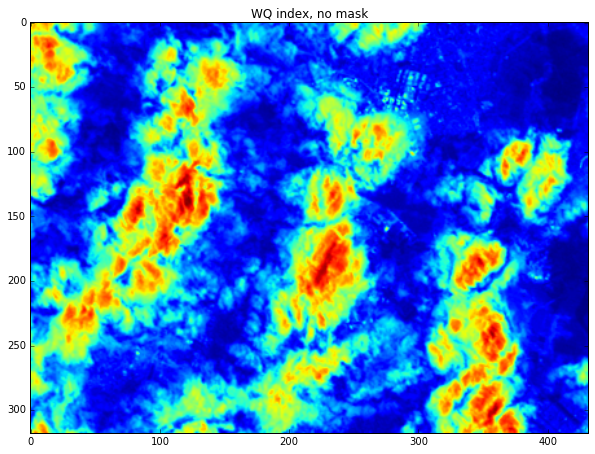

In [5]:
plt.imshow( ee.cache['aeWQ']['array_result']['aeWQ'][0].values ); plt.title('WQ index, no mask');

Let's have a look at the AE/EE's PQ mask here...

In [6]:
aePQ_array = ee.cache['aePQ']['array_result']['band_pixelquality'][0].values
aePQ_array

array([[13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       ..., 
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383]], dtype=int16)

Looks like a "normal" PQ mask.

## Loading PQ data, the "other" way...

Let's see what the PQ mask looks like when loaded using the AGDC v2.0 API's "basic"/"other"/"normal"/etc. functions (not sure what will ultimately become the "normal" way under AGDC v2.0 API!).

In [7]:
dc = datacube.api.API()
PQquery = {
    'product': 'PQ',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.06, 149.17) },
        'y' : { 'range': (-35.27, -35.33) },
        'time': { 'range': ((1996, 2, 1), (1996, 2, 28)) }
    }
}
PQdata = dc.get_data( PQquery )
print( PQdata['indices']['time'] )
print( "Same date as above?...", ee.cache['aeWQ']['array_indices']['time'][0]==PQdata['indices']['time'][0] )

['1996-02-16T09:56:11.000000000+1100']
Same date as above?... True


In [8]:
noaePQ_array = PQdata['arrays']['band_pixelquality'].isel(time=0).values
noaePQ_array

array([[13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       ..., 
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383],
       [13311, 13311, 13311, ..., 16383, 16383, 16383]], dtype=int16)

Looks like we've got the same / a (very) similar mask... Let's test:

In [9]:
print( "Do we have the same masks?", (aePQ_array == noaePQ_array).all() )

Do we have the same masks? True


So, the bottom line is: both methods (including the AE/EE approach) return the same PQ mask. This means that we can simply load up the PQ mask using the AE/EE, and then do the masking "manually". This way, we can load up both the Landsat and PQ data in one go, without having to carry out two separate queries (and then check that the two are compatible).

## PQ masking of Landsat data, the AE/EE way

So to sum up, if we want to mask our data according to the PQ info using the AE/EE, we'd do something like what follows.

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


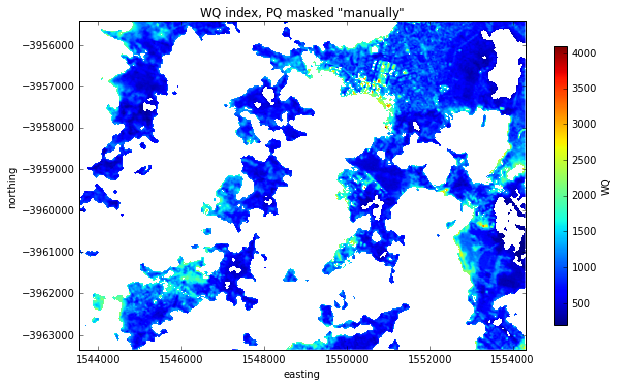

In [10]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

dimensions = { 'longitude': {'range': (149.06, 149.17)},
               'latitude':  {'range': (-35.33, -35.27)},
               'time':      {'range': ((1996, 2, 1), (1996, 2 ,28))} }

aeB2 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_20'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_5', 'NBAR'), ['band_30'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_5', 'PQ'), ['band_pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')

ee.execute_plan(ae.plan)

aeWQ_array = ee.cache['aeWQ']['array_result']['aeWQ'][0].values
aePQ_array = ee.cache['aePQ']['array_result']['band_pixelquality'][0].values
xvec = ee.cache['aeWQ']['array_indices']['x']
yvec = ee.cache['aeWQ']['array_indices']['y']

aeWQ_array[aePQ_array!=16383] = np.nan

plt.imshow( aeWQ_array, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title('WQ index, PQ masked "manually"'); plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

Again, not sure we can be fully satisfied with this PQ information, but that's really all we've got at this stage! The mask here rejects any pixel that is not exactly labelled as clear land pixel, according to the PQ info. If we're unhappy with this, we can obviously "grow" (expand) the mask to include more pixels.

## Double-checking

Just for clarity, let's check again what the AE/EE masking operation would generate here.

In [11]:
aeWQ_masked = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_masked')
ee.execute_plan(ae.plan)

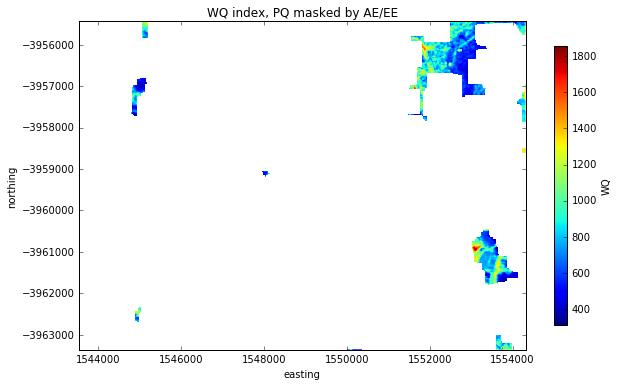

In [12]:
aeWQ_masked_array = ee.cache['aeWQ_masked']['array_result']['aeWQ_masked'][0].values
xvec = ee.cache['aeWQ_masked']['array_indices']['x']
yvec = ee.cache['aeWQ_masked']['array_indices']['y']

plt.imshow( aeWQ_masked_array, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title('WQ index, PQ masked by AE/EE'); plt.ylabel('northing'); plt.xlabel('easting');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

Yep. Something's happening here... But this result does not originate form the PQ mask itself; rather, it's a result of the masking process applied to the data, as carried out by the AE/EE.

Maybe the masking is automatically expanded somehow to cover areas on the edges of the PQ mask (?). It's unclear though what process is leading to the "square-ish" nature of this expansion. Note that a similar buffering of the original PQ mask can also be carried out using the `ndimage.binary_dilation()` approach used in _'AEWS Python Notebook 04'_.